In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os

c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv("../results/processed_ev_data.csv")
print("Processed data shape:", df.shape)
print(df.head())

Processed data shape: (1131, 25)
  User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  ...  \
0              60.712

In [4]:
# Ensure datetime format
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])

# Aggregate hourly flexible regulation
df_hourly = df.resample("1H", on="Charging Start Time").sum()[['flexible_kW']].reset_index()
print(df_hourly.head())

  Charging Start Time  flexible_kW
0 2024-01-01 00:00:00    18.213704
1 2024-01-01 01:00:00     3.701783
2 2024-01-01 02:00:00     5.738663
3 2024-01-01 03:00:00    23.837347
4 2024-01-01 04:00:00     5.888731


C:\Users\divya\AppData\Local\Temp\ipykernel_15544\3223325989.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample("1H", on="Charging Start Time").sum()[['flexible_kW']].reset_index()


In [5]:
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]

print("Train size:", train.shape, "Test size:", test.shape)

Train size: (1056, 2) Test size: (264, 2)


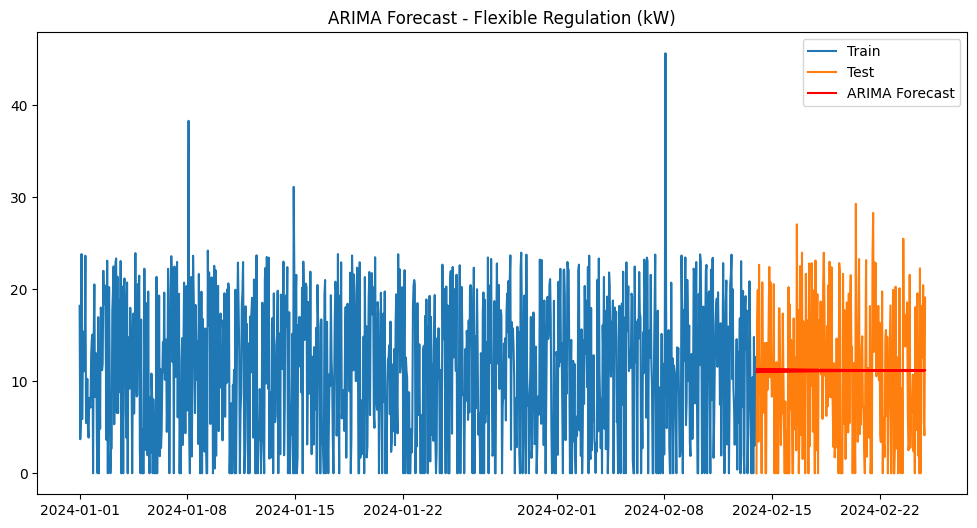

In [6]:
arima_model = ARIMA(train['flexible_kW'], order=(2,1,2))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# Plot ARIMA
plt.figure(figsize=(12,6))
plt.plot(train['Charging Start Time'], train['flexible_kW'], label="Train")
plt.plot(test['Charging Start Time'], test['flexible_kW'], label="Test")
plt.plot(test['Charging Start Time'], arima_forecast, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast - Flexible Regulation (kW)")
plt.legend()
plt.show()


21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


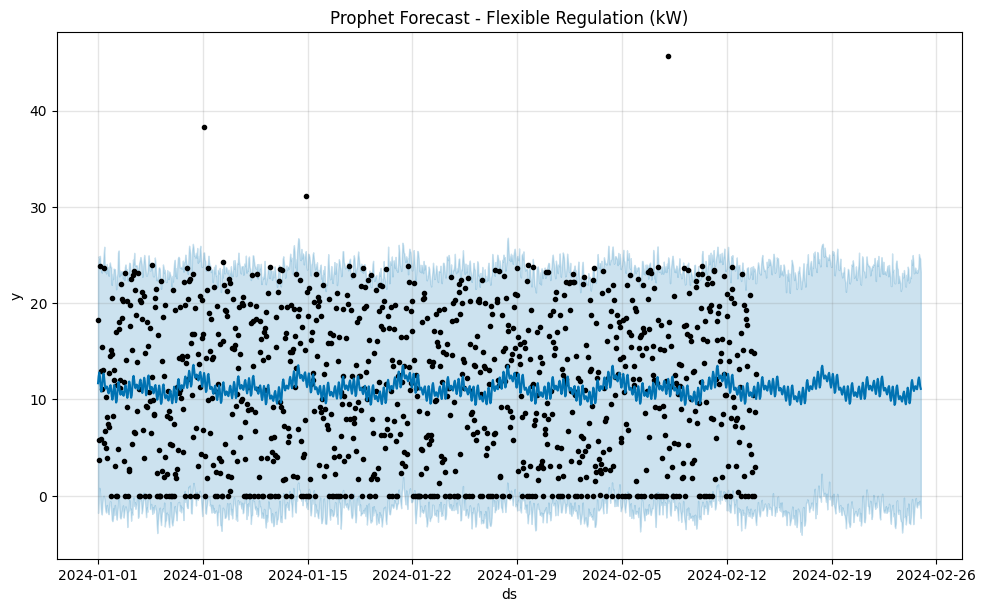

In [7]:
# Prophet needs ds (datetime) and y (target)
df_prophet = df_hourly.rename(columns={"Charging Start Time": "ds", "flexible_kW": "y"})

train_p = df_prophet.iloc[:train_size]
test_p = df_prophet.iloc[train_size:]

prophet_model = Prophet(interval_width=0.9, daily_seasonality=True)
prophet_model.fit(train_p)

future = prophet_model.make_future_dataframe(periods=len(test_p), freq="H")
forecast = prophet_model.predict(future)

# Plot Prophet
fig = prophet_model.plot(forecast)
plt.title("Prophet Forecast - Flexible Regulation (kW)")
plt.show()

In [ ]:
# ARIMA
arima_rmse = np.sqrt(mean_squared_error(test['flexible_kW'], arima_forecast))
arima_mae = mean_absolute_error(test['flexible_kW'], arima_forecast)

# Prophet
prophet_forecast = forecast.iloc[-len(test_p):]['yhat'].values
prophet_rmse = np.sqrt(mean_squared_error(test_p['y'], prophet_forecast))
prophet_mae = mean_absolute_error(test_p['y'], prophet_forecast)

print("Evaluation Results:")
print(f"ARIMA   -> Root Mean Squared Error: {arima_rmse:.2f}, Mean Absolute Error: {arima_mae:.2f}")
print(f"Prophet -> Root Mean Squared Error: {prophet_rmse:.2f}, Mean Absolute Error: {prophet_mae:.2f}")

Evaluation Results:
ARIMA   -> RMSE: 7.58, MAE: 6.46
Prophet -> RMSE: 7.54, MAE: 6.43
